<a href="https://colab.research.google.com/github/arumugamkasi/Deep-Learning-Experiments/blob/master/RiskAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Options(calls=        contractSymbol             lastTradeDate  strike  lastPrice   bid  \
0  SQQQ240524C00008500 2024-04-05 15:37:10+00:00     8.5       3.55  0.25   
1  SQQQ240524C00009000 2024-04-05 13:44:48+00:00     9.0       2.19  0.00   
2  SQQQ240524C00010000 2024-04-05 18:43:32+00:00    10.0       1.31  0.90   
3  SQQQ240524C00010500 2024-04-05 19:46:07+00:00    10.5       1.23  0.90   
4  SQQQ240524C00011000 2024-04-05 19:46:26+00:00    11.0       0.86  0.72   
5  SQQQ240524C00011500 2024-04-05 19:17:59+00:00    11.5       0.71  0.36   
6  SQQQ240524C00012500 2024-04-04 19:18:55+00:00    12.5       0.60  0.23   
7  SQQQ240524C00014000 2024-04-05 17:38:52+00:00    14.0       0.25  0.11   
8  SQQQ240524C00015000 2024-04-05 18:43:18+00:00    15.0       0.21  0.10   

    ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  4.40    1.58      80.203040       1           NaN           0.507817   
1  3.00    0.04       1.860463       3           3.0           1.

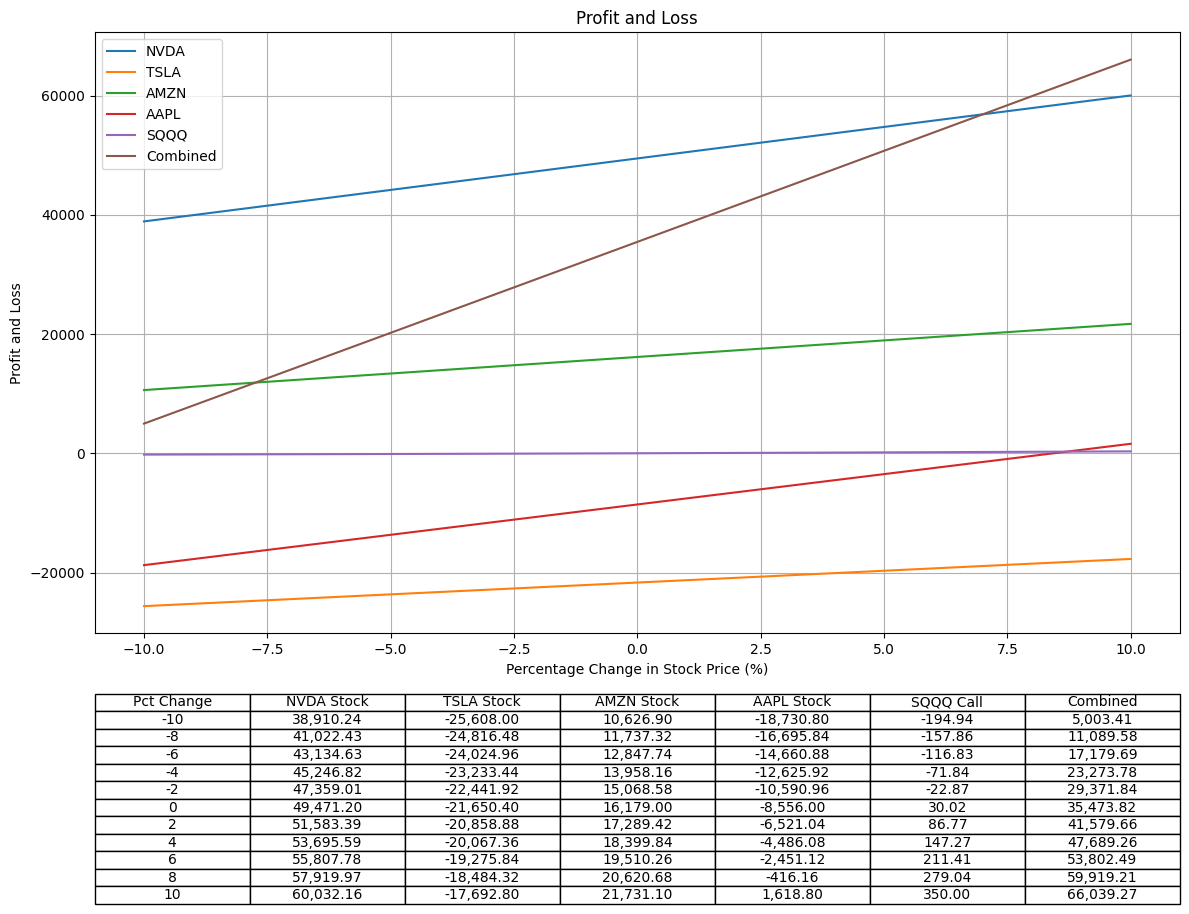

In [6]:
#from sqlalchemy.engine.result import result_tuple
#from sqlalchemy import Result
import yfinance as yf
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import date
import math
from scipy.optimize import fmin


class EuropeanOption(object):
  # Black-Scholes formula for European options
  def __init__(self,strike,expiry,option_type="Call"):
    self.strike = strike
    self.expiry = expiry
    self.option_type = option_type

  def black_scholes(self,S,r,sigma,reval_date=""):
    #print (f"Evaluating BScholes for Spot {S}, Strike {self.strike} Expiry {self.expiry} Vol {sigma} Rate {r}")
    if reval_date=="":
      revaluation_date = np.datetime64('today')
    else:
      revaluation_date = np.datetime64(reval_date)

    expiry_date_obj = np.datetime64(self.expiry)
    time_to_expiry = (expiry_date_obj - revaluation_date).astype("timedelta64[D]") / np.timedelta64(1, "D") / 365
    self.time_to_expiry = time_to_expiry

    K = self.strike
    T = self.time_to_expiry

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if self.option_type == "Call":
        N_d1 = norm.cdf(d1)
        N_d2 = norm.cdf(d2)
        option_price = S * N_d1 - K * np.exp(-r * T) * N_d2
    elif self.option_type == "Put":
        N_minus_d1 = norm.cdf(-d1)
        N_minus_d2 = norm.cdf(-d2)
        option_price = K * np.exp(-r * T) * N_minus_d2 - S * N_minus_d1
    else:
        raise ValueError("Invalid option_type. Use 'call' or 'put'.")

    return option_price

  def ImpliedVolatility(self,initial_vol,S,K,r,T,option_price):

    d1 = ( (np.log(S/K)+(r+0.5*initial_vol**2)*T) / (initial_vol*np.sqrt(T)) )
    d2 = ( np.log(S/K)+(r-0.5*initial_vol*T) / (initial_vol*np.sqrt(T)) )
    #if self.option_type=="Call":
    #  of = ( S*NORMSDIST(d1) - K*np.exp(-r*T)*NORMSDIST(d2)) - option_price
    #  of = self.black_scholes(S,r,initial_vol)
    #else:
    #  of = ( K*np.exp(-r*T)*NORMSDIST(-d2) - S*NORMSDIST(-d1) ) - option_price
    of = self.black_scholes(S,r,initial_vol) - option_price
    val = of**2
    #print("[σ]=",initial_vol,", Object Function Value:", val)
    return(val)

  def implied_volatility(self,option_price, S, r, reval_date=""):
    implied_vol = 0.3  # Initial guess for implied volatility

    if reval_date=="":
      revaluation_date = np.datetime64('today')
    else:
      revaluation_date = np.datetime64(reval_date)

    expiry_date_obj = np.datetime64(self.expiry)
    time_to_expiry = (expiry_date_obj - revaluation_date).astype("timedelta64[D]") / np.timedelta64(1, "D") / 365
    self.time_to_expiry = time_to_expiry

    K = self.strike
    T = self.time_to_expiry

    result = fmin(self.ImpliedVolatility,implied_vol,args=(S,K,r,T,option_price))
    #print (f"Computed Implied vol :{result[0]} for Option Price :{option_price}")
    return result[0]



class Portfolio(object):
  def __init__(self, insttypes,stocks,qtys,costprices,strikes,expiries):
    self.instrument_types = insttypes
    self.stocks = stocks
    self.qtys = qtys
    self.cost_prices = costprices
    self.strikes = strikes
    self.expiries = expiries
    return

  def load_market_price(self):
    self.curprices = []
    self.undprices = []
    for (instype,stock,strike,expiry) in zip(self.instrument_types,self.stocks,self.strikes,self.expiries):
      stock_price_df = yf.Ticker(stock)
      if (instype == "Stock"):
        stock_price = stock_price_df.history(period="1d")["Close"].iloc[-1]
        self.curprices.append(stock_price)
        self.undprices.append(stock_price)
      else:
        option_chain = stock_price_df.option_chain(date=expiry)
        #print (option_chain)
        if instype == "Call":
          option_price_dict = option_chain.calls[option_chain.calls["strike"] == strike].iloc[0]
          option_price = option_price_dict["lastPrice"]
        else:
          option_price_dict = option_chain.puts[option_chain.calls["strike"] == strike].iloc[0]
          option_price = option_price_dict["lastPrice"]

        stock_price= stock_price_df.history(period="1d")["Close"].iloc[-1]
        self.curprices.append(option_price)
        self.undprices.append(stock_price)

    return

  def __str__(self):
    objstr = ""
    self.load_market_price()
    for (instype,stock,qty,cost,strike,expiry,curprice,undprice) in zip(self.instrument_types,self.stocks,self.qtys,self.cost_prices,self.strikes,self.expiries,self.curprices,self.undprices):
      objstr = objstr+"\n"+"{0} Underlying :{1} Qty : {2} Cost : {3} Strike : {4} Expiry : {5} Market Price :{6} Underlying Price :{7}".format(instype,stock,qty,cost,strike,expiry,curprice,undprice)

    return objstr

  def compute_value(self):
    """
    Returns the portfolio's MTM (total amount)
    Computes latest MTM and PL and stores it in Portfolio object variables
    """

    self.load_market_price()
    self.port_value = 0.0
    self.mtms =[]
    self.investments = []
    self.pls = []

    for (instype,stock,qty,cost,strike,expiry,curprice) in zip(self.instrument_types,self.stocks,self.qtys,self.cost_prices,self.strikes,self.expiries,self.curprices):

      cost_value = qty * cost
      mtm = qty * curprice
      pl = cost_value + mtm
      self.mtms.append(mtm)
      self.investments.append(cost_value)
      self.pls.append(pl)
      self.port_value = self.port_value + qty*curprice

    return self.port_value


class RiskMatrix(object):
  def __init__(self,portfolio,pctchanges,rate=0.04):
    self.portfolio = portfolio
    self.pctchanges = pctchanges
    self.rate = rate
    self.table_headers=[]
    self.pls = [[]]
    self.table_data = []

  def compute_risk_matrix_data(self):


    for percentage_change in self.pctchanges:
    #for (instype,stock,qty,cost,strike,expiry,quoted_price,undprice) in zip(self.portfolio.instrument_types,self.portfolio.stocks,self.portfolio.qtys,self.portfolio.cost_prices,self.portfolio.strikes,self.portfolio.expiries,self.portfolio.curprices,self.portfolio.undprices):
      current_price = 0.0
      pls = []
      table_data = []
      pls.append(percentage_change)
      table_data.append(percentage_change)
      net_pl = 0
      cur_index = 1
      #for percentage_change in self.pctchanges:
      for (instype,stock,qty,cost,strike,expiry,quoted_price,undprice) in zip(self.portfolio.instrument_types,self.portfolio.stocks,self.portfolio.qtys,self.portfolio.cost_prices,self.portfolio.strikes,self.portfolio.expiries,self.portfolio.curprices,self.portfolio.undprices):
        stock_price = undprice * (1 + percentage_change / 100)
        # Calculate the Black-Scholes call and put option prices using implied volatility
        if instype == "Stock":
          current_price = stock_price
        else:
          #today_date = np.datetime64('today')
          #expiry_date_obj = np.datetime64(expiry)
          #today_date_obj = np.datetime64(today_date)
          #time_to_expiry = (expiry_date_obj - today_date_obj).astype("timedelta64[D]") / np.timedelta64(1, "D") / 365

          #print (f"Time to expiry :{time_to_expiry}")

          if instype =="Call":
            option = EuropeanOption (strike,expiry,"Call")
            implied_vol = option.implied_volatility(quoted_price,undprice,self.rate)
            #implied_vol = implied_volatility(curprice, undprice, strike, time_to_expiry, self.rate, "call")
            current_price= option.black_scholes(stock_price,self.rate,implied_vol)
            #print (f" Current Option price (Call) :{current_price} Implied Vol :{implied_vol} ")

            #current_price= black_scholes(stock_price, strike, option.expiry, self.rate, implied_vol, option_type="call")
          else:
            option = EuropeanOption (strike,expiry,"Put")
            implied_vol = option.implied_volatility(quoted_price,undprice,self.rate)
            #implied_vol = implied_volatility(curprice, undprice, strike, time_to_expiry, self.rate, "put")
            current_price= option.black_scholes(stock_price,self.rate,implied_vol)
            #print (f" Current Option price (Put) :{current_price} Implied Vol :{implied_vol} ")
            #current_price= black_scholes(stock_price, strike, time_to_expiry, self.rate, implied_vol, option_type="put")
        # Calculate profit and loss for each option
        print (f"Cost price :{cost} Current Price :{current_price}")
        pl = (current_price - cost) * qty
        pls.append(pl)
        table_data.append("{:,.2f}".format(pl))
        if cur_index == len(self.portfolio.instrument_types):
          net_pl = net_pl + pl
          pls.append(net_pl)
          table_data.append("{:,.2f}".format(net_pl))
        else:
          net_pl = net_pl + pl

        cur_index = cur_index + 1
        #pls.append("{:,.2f}".format(pl))
      #print (f" Risk matrix for {instype} {stock} : \n {pls}")
      self.pls.append(pls)
      self.table_data.append(table_data)
      self.pls = [y for y in self.pls if y!=[]]
      self.table_data = [y for y in self.table_data if y!=[]]
    return (self.pls,self.table_data)

  def plot_risk_matrix(self):
    # Plot the chart and table together
    fig, ax = plt.subplots(figsize=(12, 10))  # Adjust the figure size as needed
    plotdata = np.array(self.pls).T.tolist()
    #print (f"Transposed plot data :{plotdata}")

    #Prepare headers
    self.table_headers.append("Pct Change")

    for ins,stock in zip(self.portfolio.instrument_types,self.portfolio.stocks):
      self.table_headers.append(stock +" " +ins)
    self.table_headers.append("Combined")

    plot_stocks = self.portfolio.stocks
    plot_stocks.append("Combined")

    # Plot the chart on ax
    for stock,pltdata in zip(plot_stocks,plotdata[1:]):
      if pltdata==[]:
        continue
      #print (f"Plot data :{pltdata} X axis :{self.pctchanges}")
      #print (f"X Axis values :{list(self.pctchanges)}")
      #print (f"Y Axis values :{pltdata}")
      ax.plot(self.pctchanges, pltdata, label=stock)
      ax.set_xlabel("Percentage Change in Stock Price (%)")
      ax.set_ylabel("Profit and Loss")

    ax.set_title("Profit and Loss")
    ax.legend()
    ax.grid(True)  # Add grid lines

    # Create a table using ax.table
    #table_headers = ["Percentage Change", "NVDA Call P&L", "TQQQ Put P&L", "Combined P&L"]
    #print (f" Table Headers :{self.table_headers} Table Data :{self.table_data}")
    table = ax.table(cellText=self.table_data, colLabels=self.table_headers, cellLoc="center",bbox=[0, -0.45, 1, 0.35])

    # Adjust the table layout
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Adjust table size

    plt.tight_layout()  # Ensure plots don't overlap
    plt.show()
    return self.table_data


# Position details
expiry_date = "2024-05-24"
instrument_types = ["Stock","Stock","Stock","Stock","Call"]
stocks = ["NVDA","TSLA","AMZN","AAPL","SQQQ"]
qtys = [120,240,300,600,500]
strikes = [0,0,0,0,11]
expiries = ["","","","","2024-05-24"]
costprices = [467.82,255.11,131.14,183.84,0.8]
# End of position details


myport = Portfolio(instrument_types,stocks,qtys,costprices,strikes,expiries)
port_value = myport.compute_value()
#print (f"My Portfolio :\n {myport} \n Portfolio value : \n{port_value}")

pctchanges = range(-10, 12,2)

riskmatrix = RiskMatrix(myport,pctchanges)
pls = riskmatrix.compute_risk_matrix_data()

#print (f"My Matrix {pls}")
plot_data = riskmatrix.plot_risk_matrix()
#print(f"Plot data :{plot_data}")